In [1]:
# import necessary libraries
import pandas as pd
import pandas as pd
import numpy as np
import ast
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
teamAllMetrics = pd.read_csv('./teamAllMetrics.csv')
teamAllMetrics.head()

,gameId,teamId,gameDuration,win,teamAverageRank,matchAverageRank,totalTeamKills,totalTeamEpicMonsterKills,totalTeamTurretKills,totalTeamAllAssists,...,totalTeamMinionsKilled,resistance,teamIndegreeCentrality,teamOutdegreeCentrality,teamWeightCentralization,goldPerMin,totalTeamMininionsPerMin,totalTeamVisionPerMin,totalTeamChampExpPerMin,totalTeamAllAssistsPerMin
0,EUW1_7056642171,100,31.816667,0,13.0,13.8,39,1,7,60,...,704,1.1017,0.118852,0.094262,0.019845,2023.436354,22.126768,2.891566,2326.139340,1.885804
1,EUW1_7056642171,200,31.816667,1,14.6,13.8,41,4,8,94,...,641,0.5957,0.239691,0.139175,0.029300,2134.290204,20.146674,4.651650,2463.834468,2.954426
2,EUW1_7003965976,100,32.316667,0,8.6,8.0,28,2,3,54,...,668,0.7889,0.100877,0.048246,0.010157,1766.023724,20.670449,4.270242,2177.019082,1.670964
3,EUW1_7003965976,200,32.316667,1,7.4,8.0,30,2,9,71,...,708,0.5577,0.074675,0.178571,0.037594,2002.681795,21.908200,4.734399,2330.407427,2.197009
4,EUW1_6984979109,100,26.616667,1,5.6,6.0,44,3,11,80,...,525,0.4124,0.245283,0.129717,0.027309,2208.578585,19.724483,3.080776,2540.400751,3.005636


### Forming an analysis to see if higher gold is always a factor that results in winning games. Need to normalize on the gold earned for each team on the basis of matches

In [3]:
matchTotalMetrics = teamAllMetrics.groupby(['gameId'])[['totalTeamGold', 'totalTeamKills', 'totalTeamChampExperience', 'totalTeamMinionsKilled']].sum().reset_index()
matchTotalMetrics.rename(columns={'totalTeamGold': 'matchTotalGold', 'totalTeamKills': 'matchTotalKills', 'totalTeamChampExperience': 'matchTotalChampExperience', 'totalTeamMinionsKilled': 'matchTotalMinionsKilled'}, inplace=True)

teamAllMetrics = teamAllMetrics.merge(matchTotalMetrics, on=['gameId'], how='inner')
print(teamAllMetrics.shape)

(6978, 27)


In [4]:
teamAllMetrics['teamMatchGoldShare'] = teamAllMetrics['totalTeamGold'] / teamAllMetrics['matchTotalGold']
teamAllMetrics['teamMatchExpShare'] = teamAllMetrics['totalTeamChampExperience'] / teamAllMetrics['matchTotalChampExperience']
teamAllMetrics['teamMatchKillsShare'] = teamAllMetrics['totalTeamKills'] / teamAllMetrics['matchTotalKills']
teamAllMetrics['teamMatchMinionsShare'] = teamAllMetrics['totalTeamMinionsKilled'] / teamAllMetrics['matchTotalMinionsKilled']

In [5]:
teamAllMetrics[['gameId', 'teamId', 'teamMatchGoldShare', 'win']]

,gameId,teamId,teamMatchGoldShare,win
0,EUW1_7056642171,100,0.486669,0
1,EUW1_7056642171,200,0.513331,1
2,EUW1_7003965976,100,0.468602,0
3,EUW1_7003965976,200,0.531398,1
4,EUW1_6984979109,100,0.583260,1
...,...,...,...,...
6973,EUW1_7048327767,200,0.447520,0
6974,EUW1_7066674026,100,0.525757,1
6975,EUW1_7066674026,200,0.474243,0
6976,EUW1_7049835170,100,0.533483,1


### Only in 95 games, there are cases when lower gold team wins the game

In [6]:
teamAllMetrics[(teamAllMetrics['teamMatchGoldShare'] > 0.5) & (teamAllMetrics['win'] == 0)].describe()

lesserGoldWinningTeams = teamAllMetrics[(teamAllMetrics['teamMatchGoldShare'] > 0.5) & (teamAllMetrics['win'] == 0)]
lesserGoldWinningTeams.shape

(95, 31)

### Compare match outcomes for both the teams in for lesser winning team winning matches

In [7]:
lesserGoldWinningTeamsGameIds = lesserGoldWinningTeams['gameId']
lesserGoldWinningTeamMatches = teamAllMetrics[teamAllMetrics['gameId'].isin(lesserGoldWinningTeamsGameIds)]
print(lesserGoldWinningTeamMatches.head(10))

subsetDF = lesserGoldWinningTeamMatches[['gameId', 'teamId', 'win', 'teamMatchExpShare', 'teamMatchGoldShare', 'teamMatchKillsShare', 'resistance', 'teamIndegreeCentrality', 'teamOutdegreeCentrality']]
subsetDF.head(10)

### show some form of graph in which the team with lesser gold wins on account of graph based metrics

              gameId  teamId  gameDuration  win  teamAverageRank  \
16   EUW1_6983223964     100     39.716667    0              4.0   
17   EUW1_6983223964     200     39.716667    1              3.4   
22   EUW1_7063407469     100     31.866667    0             13.6   
23   EUW1_7063407469     200     31.866667    1             13.8   
50   EUW1_7064847345     100     38.166667    1             23.6   
51   EUW1_7064847345     200     38.166667    0             25.0   
122  EUW1_7060222753     100     36.166667    1             13.2   
123  EUW1_7060222753     200     36.166667    0             13.0   
326  EUW1_7005140488     100     41.400000    0             28.6   
327  EUW1_7005140488     200     41.400000    1             29.0   

     matchAverageRank  totalTeamKills  totalTeamEpicMonsterKills  \
16                3.7              57                          2   
17                3.7              46                          3   
22               13.7              41          

,gameId,teamId,win,teamMatchExpShare,teamMatchGoldShare,teamMatchKillsShare,resistance,teamIndegreeCentrality,teamOutdegreeCentrality
16,EUW1_6983223964,100,0,0.504721,0.514605,0.553398,0.3724,0.079545,0.079545
17,EUW1_6983223964,200,1,0.495279,0.485395,0.446602,0.6704,0.082031,0.121094
22,EUW1_7063407469,100,0,0.537378,0.524179,0.539474,0.7413,0.186508,0.154762
23,EUW1_7063407469,200,1,0.462622,0.475821,0.460526,0.8036,0.083333,0.116667
50,EUW1_7064847345,100,1,0.466068,0.486133,0.463158,0.5447,0.188144,0.180412
51,EUW1_7064847345,200,0,0.533932,0.513867,0.536842,0.4429,0.336735,0.140306
122,EUW1_7060222753,100,1,0.469294,0.488047,0.511111,0.4576,0.166667,0.212366
123,EUW1_7060222753,200,0,0.530706,0.511953,0.488889,0.3869,0.260870,0.115217
326,EUW1_7005140488,100,0,0.498661,0.502889,0.514706,1.2192,0.483333,0.196667
327,EUW1_7005140488,200,1,0.501339,0.497111,0.485294,0.5061,0.236111,0.072222


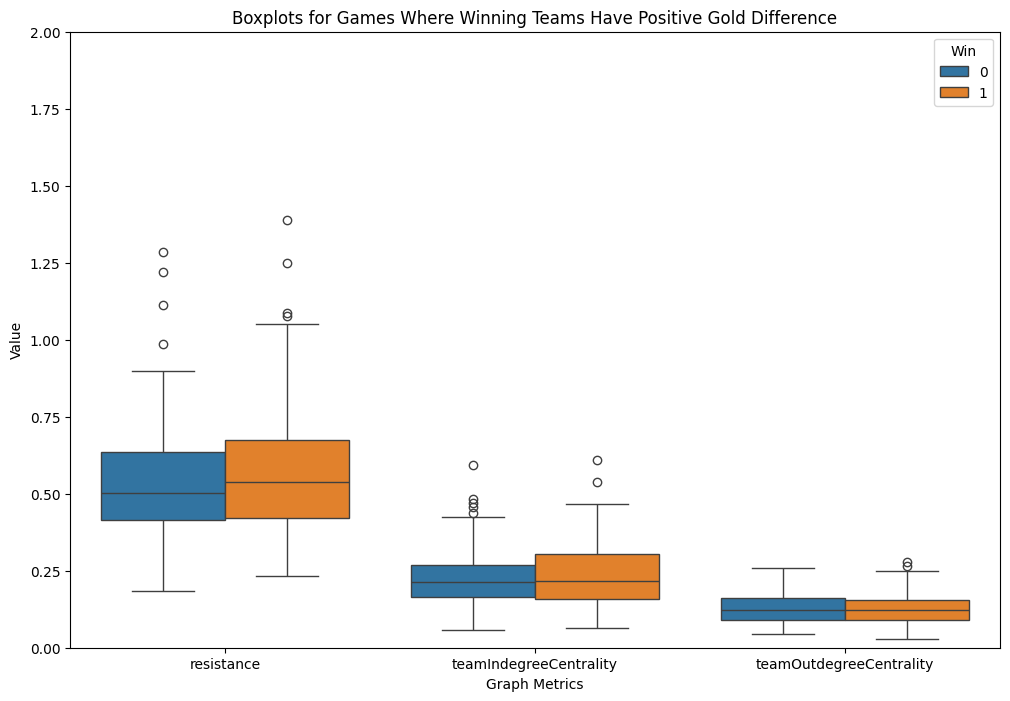

In [8]:
import seaborn as sns

# Melt the dataframe to long format
subsetDF_melted = pd.melt(subsetDF, id_vars=["win"], 
                    value_vars=["resistance", "teamIndegreeCentrality", "teamOutdegreeCentrality"],
                    var_name="metrics", value_name="Value")

# Plotting function with the melted data
plt.figure(figsize=(12, 8))
sns.boxplot(x="metrics", y="Value", hue="win", data=subsetDF_melted)
plt.title('Boxplots for Games Where Winning Teams Have Positive Gold Difference')
plt.xlabel('Graph Metrics')
plt.ylabel('Value')
plt.ylim([0, 2])
plt.legend(title='Win', loc='upper right')
plt.show()

### Check for Multi-Collinearity Between Variables - Using Variance Inflation Factor

In [9]:
teamAllMetrics['totalTeamKillsPerMin'] = teamAllMetrics['totalTeamKills'] / teamAllMetrics['gameDuration']

In [10]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# using original set of metrics before, we had share of the match
teamDF = teamAllMetrics[[   'gameId', 'teamId', 'win', 'teamAverageRank', 'totalTeamKillsPerMin', 'totalTeamAllAssistsPerMin', 'totalTeamEpicMonsterKills', 'totalTeamTurretKills',
                            'teamMatchGoldShare', 'goldPerMin', 'totalTeamChampExpPerMin', 'teamMatchMinionsShare', 'totalTeamVisionPerMin',
                            'resistance', 'teamIndegreeCentrality',
                            'teamOutdegreeCentrality', 'teamWeightCentralization'
                        ]]

# subset of features from teamDF that will be used for checking collinearity using VIF
y, X = dmatrices('win~teamAverageRank+totalTeamKillsPerMin+totalTeamAllAssistsPerMin+totalTeamEpicMonsterKills+totalTeamTurretKills+teamMatchGoldShare+goldPerMin+totalTeamChampExpPerMin+teamMatchMinionsShare+totalTeamVisionPerMin+resistance+teamIndegreeCentrality+teamOutdegreeCentrality', data=teamDF, return_type='dataframe')

In [11]:
vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_df

,variable,VIF
0,Intercept,817.922215
1,teamAverageRank,2.286863
2,totalTeamKillsPerMin,7.770713
3,totalTeamAllAssistsPerMin,5.726065
4,totalTeamEpicMonsterKills,2.481991
5,totalTeamTurretKills,5.037589
6,teamMatchGoldShare,6.764437
7,goldPerMin,16.435865
8,totalTeamChampExpPerMin,4.867414
9,teamMatchMinionsShare,1.364608


### Check for multi-collinearity using pearson correlation coefficient

In [12]:
from scipy import stats

# Correlation matrix
teamDF_features = teamDF[['teamAverageRank', 'totalTeamKillsPerMin', 'totalTeamAllAssistsPerMin', 'totalTeamEpicMonsterKills', 'totalTeamTurretKills',
                        'teamMatchGoldShare', 'goldPerMin', 'totalTeamChampExpPerMin', 'teamMatchMinionsShare', 'totalTeamVisionPerMin',
                        'resistance', 'teamIndegreeCentrality',
                        'teamOutdegreeCentrality', 'teamWeightCentralization'
                    ]]

correlation_matrix = teamDF_features.corr()

# Function to calculate p-values
def correlation_test(x, y):
    return stats.pearsonr(x, y)

# Calculating p-values
p_values = pd.DataFrame(index=teamDF_features.columns, columns=teamDF_features.columns)

for col1 in teamDF_features.columns:
    for col2 in teamDF_features.columns:
        if col1 == col2:
            p_values[col1][col2] = np.nan  # NaN for the diagonal
        else:
            corr_test = correlation_test(teamDF_features[col1], teamDF_features[col2])
            p_values[col1][col2] = corr_test[1]  # Extract the p-value

# print(p_values)

print("Correlation Matrix:")

teamDF_features.drop(['goldPerMin', 'teamMatchGoldShare', 'teamWeightCentralization'], axis=1, inplace=True)
correlation_matrix

Correlation Matrix:


/tmp/ipykernel_72159/1140148357.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  p_values[col1][col2] = np.nan  # NaN for the diagonal
/tmp/ipykernel_72159/1140148357.py:25: FutureWarning: ChainedAssignmentError: behaviour will change in

,teamAverageRank,totalTeamKillsPerMin,totalTeamAllAssistsPerMin,totalTeamEpicMonsterKills,totalTeamTurretKills,teamMatchGoldShare,goldPerMin,totalTeamChampExpPerMin,teamMatchMinionsShare,totalTeamVisionPerMin,resistance,teamIndegreeCentrality,teamOutdegreeCentrality,teamWeightCentralization
teamAverageRank,1.000000,-0.005438,0.139073,-0.041038,0.004340,0.022468,0.241423,0.086794,0.010572,0.496481,-0.039756,0.038079,0.073456,0.073456
totalTeamKillsPerMin,-0.005438,1.000000,0.857671,0.488822,0.625217,0.724797,0.846709,0.684537,0.223392,0.166159,-0.569105,-0.209815,-0.109912,-0.109912
totalTeamAllAssistsPerMin,0.139073,0.857671,1.000000,0.560140,0.652764,0.736558,0.817216,0.676828,0.211041,0.309452,-0.660762,-0.211400,-0.198223,-0.198223
totalTeamEpicMonsterKills,-0.041038,0.488822,0.560140,1.000000,0.663187,0.643788,0.577770,0.687292,0.144695,0.319139,-0.462408,-0.145699,-0.138930,-0.138930
totalTeamTurretKills,0.004340,0.625217,0.652764,0.663187,1.000000,0.858250,0.799148,0.739531,0.291630,0.302208,-0.476177,-0.168403,-0.090848,-0.090848
teamMatchGoldShare,0.022468,0.724797,0.736558,0.643788,0.858250,1.000000,0.858629,0.783563,0.421933,0.295079,-0.504019,-0.162355,-0.091913,-0.091913
goldPerMin,0.241423,0.846709,0.817216,0.577770,0.799148,0.858629,1.000000,0.845927,0.360640,0.359938,-0.557448,-0.188306,-0.084758,-0.084758
totalTeamChampExpPerMin,0.086794,0.684537,0.676828,0.687292,0.739531,0.783563,0.845927,1.000000,0.332689,0.315662,-0.532467,-0.167368,-0.119512,-0.119512
teamMatchMinionsShare,0.010572,0.223392,0.211041,0.144695,0.291630,0.421933,0.360640,0.332689,1.000000,0.077746,-0.163873,-0.060808,-0.008373,-0.008373
totalTeamVisionPerMin,0.496481,0.166159,0.309452,0.319139,0.302208,0.295079,0.359938,0.315662,0.077746,1.000000,-0.280062,-0.090057,-0.083020,-0.083020


## Fitting and prediction using in-game + graph metrics

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [14]:
# splitting games into train-test split
game_ids = teamDF['gameId'].unique()
train_games, test_games = train_test_split(game_ids, test_size=0.2, random_state=245)

train_df = teamDF[teamDF['gameId'].isin(train_games)]
test_df = teamDF[teamDF['gameId'].isin(test_games)]

X_train = train_df[['teamAverageRank', 'totalTeamKillsPerMin', 'totalTeamAllAssistsPerMin', 'totalTeamEpicMonsterKills', 'totalTeamTurretKills', 'totalTeamChampExpPerMin', 'teamMatchMinionsShare', 'totalTeamVisionPerMin', 'resistance', 'teamIndegreeCentrality', 'teamOutdegreeCentrality']]
y_train = train_df['win']

X_test = test_df[['teamAverageRank', 'totalTeamKillsPerMin', 'totalTeamAllAssistsPerMin', 'totalTeamEpicMonsterKills', 'totalTeamTurretKills', 'totalTeamChampExpPerMin', 'teamMatchMinionsShare', 'totalTeamVisionPerMin', 'resistance', 'teamIndegreeCentrality', 'teamOutdegreeCentrality']]
y_test = test_df['win']

features_names = X_train.columns

### Binary Logistic Regression

In [15]:
# check for results with and without scaling
# Scaling data features to avoid model skewing; performing scaling may not be necessary, because we have transformed the data!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

In [16]:
# Fit the model
model = LogisticRegression(solver='lbfgs', max_iter=400)
model.fit(X_train, y_train) # use X_train_scaled to fit instead

features_names = X_train.columns
coefficients = model.coef_
importances = coefficients[0]
blr_feature_importances = dict(zip(features_names, importances))

y_pred = model.predict(X_test)

/home/sajana/Collective-Intelligence-LoL/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
# p-values using statsmodels
import statsmodels.api as sm
X = sm.add_constant(X_train) # adding a constant intercept term
logit_model = sm.Logit(y_train, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.143136
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                 5582
Model:                          Logit   Df Residuals:                     5570
Method:                           MLE   Df Model:                           11
Date:                Thu, 22 Aug 2024   Pseudo R-squ.:                  0.7935
Time:                        17:00:50   Log-Likelihood:                -798.98
converged:                       True   LL-Null:                       -3869.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       -38.3513      2.055    -18.667      0.000     -42.

In [18]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate classification report
class_report = classification_report(y_test, y_pred)

print(blr_feature_importances)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

{'teamAverageRank': np.float64(0.00450946450422257), 'totalTeamKillsPerMin': np.float64(1.977551612345296), 'totalTeamAllAssistsPerMin': np.float64(1.5748417818803855), 'totalTeamEpicMonsterKills': np.float64(0.18405658666242955), 'totalTeamTurretKills': np.float64(0.9540366751839654), 'totalTeamChampExpPerMin': np.float64(0.0037119174202579616), 'teamMatchMinionsShare': np.float64(-5.51501000981392), 'totalTeamVisionPerMin': np.float64(-0.03310868898677392), 'resistance': np.float64(0.8958919856927877), 'teamIndegreeCentrality': np.float64(-0.410289247846748), 'teamOutdegreeCentrality': np.float64(0.43761721751322424)}
Accuracy: 0.9355300859598854
Confusion Matrix:
 [[644  54]
 [ 36 662]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93       698
           1       0.92      0.95      0.94       698

    accuracy                           0.94      1396
   macro avg       0.94      0.94      0.94      1396
weigh

### Decision Tree Classifier

In [19]:
from sklearn.tree import DecisionTreeClassifier

dtmodel = DecisionTreeClassifier()
dtmodel.fit(X_train, y_train)
dt_importances = dtmodel.feature_importances_
feature_importances = dict(zip(features_names, dt_importances))


dt_y_pred = dtmodel.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, dt_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, dt_y_pred)

# Calculate classification report
class_report = classification_report(y_test, dt_y_pred)

print(feature_importances)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

{'teamAverageRank': np.float64(0.010376941907088386), 'totalTeamKillsPerMin': np.float64(0.019732392238996987), 'totalTeamAllAssistsPerMin': np.float64(0.05163732677527227), 'totalTeamEpicMonsterKills': np.float64(0.007333877346773507), 'totalTeamTurretKills': np.float64(0.7386543483001954), 'totalTeamChampExpPerMin': np.float64(0.07045798154273678), 'teamMatchMinionsShare': np.float64(0.028781702379453277), 'totalTeamVisionPerMin': np.float64(0.016910961539262727), 'resistance': np.float64(0.026571059386659903), 'teamIndegreeCentrality': np.float64(0.01621528907162157), 'teamOutdegreeCentrality': np.float64(0.013328119511939266)}
Accuracy: 0.9011461318051576
Confusion Matrix:
 [[626  72]
 [ 66 632]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       698
           1       0.90      0.91      0.90       698

    accuracy                           0.90      1396
   macro avg       0.90      0.90      0.90     

### Random Forest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

rfmodel = RandomForestClassifier(n_estimators=16, max_depth=8, bootstrap=True)
rfmodel.fit(X_train, y_train)
rf_importances = rfmodel.feature_importances_ 
rf_feature_importances = dict(zip(features_names, rf_importances))
rf_y_pred = rfmodel.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, rf_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, rf_y_pred)

# Calculate classification report
class_report = classification_report(y_test, rf_y_pred)

print(rf_feature_importances)
print('RF Accuracy:', accuracy)
print('RF Confusion Matrix:\n', conf_matrix)
print('RF Classification Report:\n', class_report)

{'teamAverageRank': np.float64(0.009009488746295416), 'totalTeamKillsPerMin': np.float64(0.06331352784951651), 'totalTeamAllAssistsPerMin': np.float64(0.0959804687962103), 'totalTeamEpicMonsterKills': np.float64(0.06359439347087599), 'totalTeamTurretKills': np.float64(0.48898039906791), 'totalTeamChampExpPerMin': np.float64(0.20305455359554112), 'teamMatchMinionsShare': np.float64(0.028661893685547016), 'totalTeamVisionPerMin': np.float64(0.009496191054772169), 'resistance': np.float64(0.020393460946434544), 'teamIndegreeCentrality': np.float64(0.008462515559232867), 'teamOutdegreeCentrality': np.float64(0.00905310722766405)}
RF Accuracy: 0.9340974212034384
RF Confusion Matrix:
 [[645  53]
 [ 39 659]]
RF Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       698
           1       0.93      0.94      0.93       698

    accuracy                           0.93      1396
   macro avg       0.93      0.93      0.93 

### XG Boost Classifier

In [21]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    n_estimators = 100,
    eval_metric='logloss',
    learning_rate = 0.05
)

xgb_model.fit(X_train, y_train)
xgb_importances = xgb_model.feature_importances_ 
xgb_feature_importances = dict(zip(features_names, xgb_importances))

xgb_y_pred = xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, xgb_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, xgb_y_pred)

# Calculate classification report
class_report = classification_report(y_test, xgb_y_pred)

print(xgb_feature_importances)
print('XGB Accuracy:', accuracy)
print('XGB Confusion Matrix:\n', conf_matrix)
print('XGB Classification Report:\n', class_report)

{'teamAverageRank': np.float32(0.012553202), 'totalTeamKillsPerMin': np.float32(0.014078192), 'totalTeamAllAssistsPerMin': np.float32(0.040552624), 'totalTeamEpicMonsterKills': np.float32(0.02922792), 'totalTeamTurretKills': np.float32(0.7869331), 'totalTeamChampExpPerMin': np.float32(0.044882912), 'teamMatchMinionsShare': np.float32(0.01940189), 'totalTeamVisionPerMin': np.float32(0.0139729595), 'resistance': np.float32(0.017440544), 'teamIndegreeCentrality': np.float32(0.010220571), 'teamOutdegreeCentrality': np.float32(0.01073606)}
XGB Accuracy: 0.9362464183381088
XGB Confusion Matrix:
 [[651  47]
 [ 42 656]]
XGB Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94       698
           1       0.93      0.94      0.94       698

    accuracy                           0.94      1396
   macro avg       0.94      0.94      0.94      1396
weighted avg       0.94      0.94      0.94      1396



## Fitting and predicition using graph metrics only

In [22]:
# splitting games into train-test split
game_ids = teamDF['gameId'].unique()
train_games, test_games = train_test_split(game_ids, test_size=0.2, random_state=25)

train_df = teamDF[teamDF['gameId'].isin(train_games)]
test_df = teamDF[teamDF['gameId'].isin(test_games)]

X_train = train_df[['resistance', 'teamIndegreeCentrality', 'teamOutdegreeCentrality']]
y_train = train_df['win']

X_test = test_df[['resistance', 'teamIndegreeCentrality', 'teamOutdegreeCentrality']]
y_test = test_df['win']

features_names = X_train.columns

### Binary Logistic Regression

In [23]:
# Fit the model
model = LogisticRegression(solver='lbfgs', max_iter=400)
model.fit(X_train, y_train) # use X_train_scaled to fit instead

features_names = X_train.columns
coefficients = model.coef_
importances = coefficients[0]
blr_feature_importances = dict(zip(features_names, importances))

y_pred = model.predict(X_test)

In [24]:
# p-values using statsmodels
import statsmodels.api as sm
X = sm.add_constant(X_train) # adding a constant intercept term
logit_model = sm.Logit(y_train, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.504557
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                 5582
Model:                          Logit   Df Residuals:                     5578
Method:                           MLE   Df Model:                            3
Date:                Thu, 22 Aug 2024   Pseudo R-squ.:                  0.2721
Time:                        17:00:51   Log-Likelihood:                -2816.4
converged:                       True   LL-Null:                       -3869.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       2.2922      0.116     19.839      0.000       2.066   

In [25]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate classification report
class_report = classification_report(y_test, y_pred)

print(blr_feature_importances)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

{'resistance': np.float64(-3.8061384236895335), 'teamIndegreeCentrality': np.float64(0.716686341552883), 'teamOutdegreeCentrality': np.float64(3.5019149300632857)}
Accuracy: 0.7707736389684814
Confusion Matrix:
 [[464 234]
 [ 86 612]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.66      0.74       698
           1       0.72      0.88      0.79       698

    accuracy                           0.77      1396
   macro avg       0.78      0.77      0.77      1396
weighted avg       0.78      0.77      0.77      1396



### Decision Tree Classifier

In [26]:
from sklearn.tree import DecisionTreeClassifier

dtmodel = DecisionTreeClassifier()
dtmodel.fit(X_train, y_train)
dt_importances = dtmodel.feature_importances_
feature_importances = dict(zip(features_names, dt_importances))


dt_y_pred = dtmodel.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, dt_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, dt_y_pred)

# Calculate classification report
class_report = classification_report(y_test, dt_y_pred)

print(feature_importances)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

{'resistance': np.float64(0.5905255409068825), 'teamIndegreeCentrality': np.float64(0.19673807122859932), 'teamOutdegreeCentrality': np.float64(0.21273638786451815)}
Accuracy: 0.6575931232091691
Confusion Matrix:
 [[447 251]
 [227 471]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.64      0.65       698
           1       0.65      0.67      0.66       698

    accuracy                           0.66      1396
   macro avg       0.66      0.66      0.66      1396
weighted avg       0.66      0.66      0.66      1396



### Random Forest Classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier

rfmodel = RandomForestClassifier(n_estimators=16, max_depth=8, bootstrap=True)
rfmodel.fit(X_train, y_train)
rf_importances = rfmodel.feature_importances_ 
rf_feature_importances = dict(zip(features_names, rf_importances))
rf_y_pred = rfmodel.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, rf_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, rf_y_pred)

# Calculate classification report
class_report = classification_report(y_test, rf_y_pred)

print(rf_feature_importances)
print('RF Accuracy:', accuracy)
print('RF Confusion Matrix:\n', conf_matrix)
print('RF Classification Report:\n', class_report)

{'resistance': np.float64(0.8006942549986773), 'teamIndegreeCentrality': np.float64(0.09963543654717658), 'teamOutdegreeCentrality': np.float64(0.09967030845414616)}
RF Accuracy: 0.7686246418338109
RF Confusion Matrix:
 [[493 205]
 [118 580]]
RF Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.71      0.75       698
           1       0.74      0.83      0.78       698

    accuracy                           0.77      1396
   macro avg       0.77      0.77      0.77      1396
weighted avg       0.77      0.77      0.77      1396



### XG Boost Classifier

In [28]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    n_estimators = 100,
    eval_metric='logloss',
    learning_rate = 0.05
)

xgb_model.fit(X_train, y_train)
xgb_importances = xgb_model.feature_importances_ 
xgb_feature_importances = dict(zip(features_names, xgb_importances))

xgb_y_pred = xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, xgb_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, xgb_y_pred)

# Calculate classification report
class_report = classification_report(y_test, xgb_y_pred)

print(xgb_feature_importances)
print('XGB Accuracy:', accuracy)
print('XGB Confusion Matrix:\n', conf_matrix)
print('XGB Classification Report:\n', class_report)

{'resistance': np.float32(0.81616277), 'teamIndegreeCentrality': np.float32(0.08216903), 'teamOutdegreeCentrality': np.float32(0.10166818)}
XGB Accuracy: 0.7650429799426934
XGB Confusion Matrix:
 [[491 207]
 [121 577]]
XGB Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.70      0.75       698
           1       0.74      0.83      0.78       698

    accuracy                           0.77      1396
   macro avg       0.77      0.77      0.76      1396
weighted avg       0.77      0.77      0.76      1396



## Fitting and Prediction with In-Game Metrics only

In [29]:
# splitting games into train-test split
game_ids = teamDF['gameId'].unique()
train_games, test_games = train_test_split(game_ids, test_size=0.2, random_state=245)

train_df = teamDF[teamDF['gameId'].isin(train_games)]
test_df = teamDF[teamDF['gameId'].isin(test_games)]

X_train = train_df[['teamAverageRank', 'totalTeamKillsPerMin', 'totalTeamAllAssistsPerMin', 'totalTeamEpicMonsterKills', 'totalTeamTurretKills', 'totalTeamChampExpPerMin', 'teamMatchMinionsShare', 'totalTeamVisionPerMin']]
y_train = train_df['win']

X_test = test_df[['teamAverageRank', 'totalTeamKillsPerMin', 'totalTeamAllAssistsPerMin', 'totalTeamEpicMonsterKills', 'totalTeamTurretKills', 'totalTeamChampExpPerMin', 'teamMatchMinionsShare', 'totalTeamVisionPerMin']]
y_test = test_df['win']

features_names = X_train.columns

### Binary Logistic Regression

In [30]:
# Fit the model
model = LogisticRegression(solver='lbfgs', max_iter=400)
model.fit(X_train, y_train) # use X_train_scaled to fit instead

features_names = X_train.columns
coefficients = model.coef_
importances = coefficients[0]
blr_feature_importances = dict(zip(features_names, importances))

y_pred = model.predict(X_test)

/home/sajana/Collective-Intelligence-LoL/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
# p-values using statsmodels
import statsmodels.api as sm
X = sm.add_constant(X_train) # adding a constant intercept term
logit_model = sm.Logit(y_train, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.148430
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                 5582
Model:                          Logit   Df Residuals:                     5573
Method:                           MLE   Df Model:                            8
Date:                Thu, 22 Aug 2024   Pseudo R-squ.:                  0.7859
Time:                        17:00:52   Log-Likelihood:                -828.54
converged:                       True   LL-Null:                       -3869.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       -35.0120      1.942    -18.033      0.000     -38.

In [32]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate classification report
class_report = classification_report(y_test, y_pred)

print(blr_feature_importances)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

{'teamAverageRank': np.float64(-0.007974256611535365), 'totalTeamKillsPerMin': np.float64(-0.9041050697577507), 'totalTeamAllAssistsPerMin': np.float64(2.188162423147209), 'totalTeamEpicMonsterKills': np.float64(0.04231901877933854), 'totalTeamTurretKills': np.float64(0.9465675788572776), 'totalTeamChampExpPerMin': np.float64(0.005180039635986114), 'teamMatchMinionsShare': np.float64(-1.3663651179059804), 'totalTeamVisionPerMin': np.float64(-0.1137945942755588)}
Accuracy: 0.9290830945558739
Confusion Matrix:
 [[640  58]
 [ 41 657]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       698
           1       0.92      0.94      0.93       698

    accuracy                           0.93      1396
   macro avg       0.93      0.93      0.93      1396
weighted avg       0.93      0.93      0.93      1396



### Decision Tree Classifier

In [33]:
from sklearn.tree import DecisionTreeClassifier

dtmodel = DecisionTreeClassifier()
dtmodel.fit(X_train, y_train)
dt_importances = dtmodel.feature_importances_
feature_importances = dict(zip(features_names, dt_importances))


dt_y_pred = dtmodel.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, dt_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, dt_y_pred)

# Calculate classification report
class_report = classification_report(y_test, dt_y_pred)

print(feature_importances)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

{'teamAverageRank': np.float64(0.023031081843070386), 'totalTeamKillsPerMin': np.float64(0.024897910359359766), 'totalTeamAllAssistsPerMin': np.float64(0.056213312427791304), 'totalTeamEpicMonsterKills': np.float64(0.012682483423532596), 'totalTeamTurretKills': np.float64(0.73982885277377), 'totalTeamChampExpPerMin': np.float64(0.07989808161602029), 'teamMatchMinionsShare': np.float64(0.04095820516478239), 'totalTeamVisionPerMin': np.float64(0.022490072391673267)}
Accuracy: 0.9018624641833811
Confusion Matrix:
 [[635  63]
 [ 74 624]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90       698
           1       0.91      0.89      0.90       698

    accuracy                           0.90      1396
   macro avg       0.90      0.90      0.90      1396
weighted avg       0.90      0.90      0.90      1396



### Random Forest Classifier

In [34]:
rfmodel = RandomForestClassifier(n_estimators=16, max_depth=8, bootstrap=True)
rfmodel.fit(X_train, y_train)
rf_importances = rfmodel.feature_importances_ 
rf_feature_importances = dict(zip(features_names, rf_importances))
rf_y_pred = rfmodel.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, rf_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, rf_y_pred)

# Calculate classification report
class_report = classification_report(y_test, rf_y_pred)

print(rf_feature_importances)
print('RF Accuracy:', accuracy)
print('RF Confusion Matrix:\n', conf_matrix)
print('RF Classification Report:\n', class_report)

{'teamAverageRank': np.float64(0.013013414224322018), 'totalTeamKillsPerMin': np.float64(0.055005757567174664), 'totalTeamAllAssistsPerMin': np.float64(0.10605887870900747), 'totalTeamEpicMonsterKills': np.float64(0.023317251678358564), 'totalTeamTurretKills': np.float64(0.6087077057669408), 'totalTeamChampExpPerMin': np.float64(0.14980409532769046), 'teamMatchMinionsShare': np.float64(0.025605133905839794), 'totalTeamVisionPerMin': np.float64(0.018487762820666265)}
RF Accuracy: 0.9297994269340975
RF Confusion Matrix:
 [[641  57]
 [ 41 657]]
RF Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       698
           1       0.92      0.94      0.93       698

    accuracy                           0.93      1396
   macro avg       0.93      0.93      0.93      1396
weighted avg       0.93      0.93      0.93      1396



### XG Boost Classifier

In [35]:
xgb_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    n_estimators = 100,
    eval_metric='logloss',
    learning_rate = 0.05
)

xgb_model.fit(X_train, y_train)
xgb_importances = xgb_model.feature_importances_ 
xgb_feature_importances = dict(zip(features_names, xgb_importances))

xgb_y_pred = xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, xgb_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, xgb_y_pred)

# Calculate classification report
class_report = classification_report(y_test, xgb_y_pred)

print(xgb_feature_importances)
print('XGB Accuracy:', accuracy)
print('XGB Confusion Matrix:\n', conf_matrix)
print('XGB Classification Report:\n', class_report)

{'teamAverageRank': np.float32(0.011776583), 'totalTeamKillsPerMin': np.float32(0.014223566), 'totalTeamAllAssistsPerMin': np.float32(0.043578655), 'totalTeamEpicMonsterKills': np.float32(0.02617367), 'totalTeamTurretKills': np.float32(0.82070965), 'totalTeamChampExpPerMin': np.float32(0.048173852), 'teamMatchMinionsShare': np.float32(0.021227848), 'totalTeamVisionPerMin': np.float32(0.014136148)}
XGB Accuracy: 0.9340974212034384
XGB Confusion Matrix:
 [[652  46]
 [ 46 652]]
XGB Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       698
           1       0.93      0.93      0.93       698

    accuracy                           0.93      1396
   macro avg       0.93      0.93      0.93      1396
weighted avg       0.93      0.93      0.93      1396



## Dimensionality Reduction

### Scree Analysis

In [36]:
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

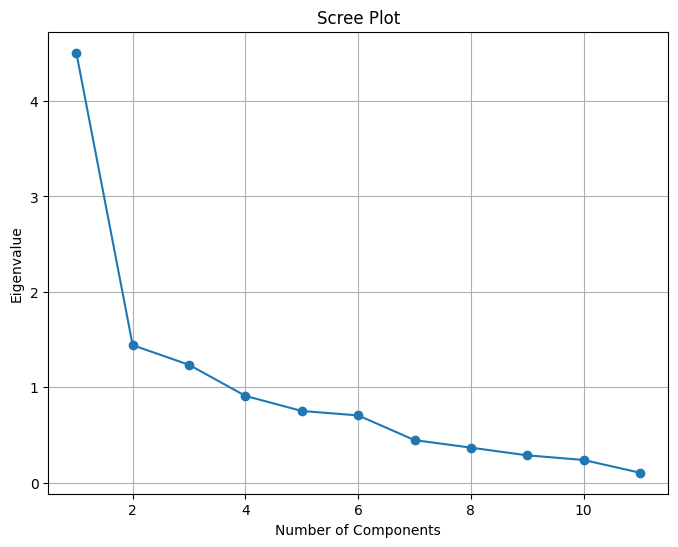

In [37]:
# scale features
scaler = StandardScaler()
teamDF_features_scaled = scaler.fit_transform(teamDF_features)

pca = PCA()
pca.fit(teamDF_features_scaled)


# Plot the Scree Plot
plt.figure(figsize=(8,6))
plt.plot(np.arange(1, len(pca.explained_variance_)+1), pca.explained_variance_, marker='o')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

### Factor Analysis; scree plot suggests number of latent components to be 3

In [38]:
# performing KMO test on the dataset to see if dataframe is suitable for factor analysis
from factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(teamDF_features_scaled)

# Print the results
print(f"KMO Overall: {kmo_model:.4f}")

# If you want to see individual KMO values for each variable:
print("Individual KMO values:\n", kmo_all)

KMO Overall: 0.8012
Individual KMO values:
 [0.37802356 0.76300192 0.7772188  0.82945645 0.90263685 0.85374589
 0.79861875 0.70383441 0.90110887 0.81408084 0.6700985 ]


In [39]:
# Perform Factor Analysis
fa = FactorAnalysis(n_components=3, rotation='varimax')  # Adjust n_components based on Scree Plot
fa.fit(teamDF_features_scaled)
factor_loadings = fa.components_.T

# factor loadings for each feature column
loadings_df = pd.DataFrame(factor_loadings, index=teamDF_features.columns, columns=[f'Factor{i+1}' for i in range(factor_loadings.shape[1])])

# compute factor scores
factor_scores = fa.transform(teamDF_features_scaled)
factor_scores_df = pd.DataFrame(factor_scores, columns=[f'Factor{i+1}' for i in range(factor_scores.shape[1])])

In [40]:
# Print factor loadings
loadings_df

,Factor1,Factor2,Factor3
teamAverageRank,0.066579,0.630709,0.117823
totalTeamKillsPerMin,0.844187,-0.034487,-0.282575
totalTeamAllAssistsPerMin,0.956748,0.151940,-0.193895
totalTeamEpicMonsterKills,0.432227,0.129477,-0.632276
totalTeamTurretKills,0.534618,0.094740,-0.645977
totalTeamChampExpPerMin,0.553774,0.119417,-0.679584
teamMatchMinionsShare,0.163728,-0.001072,-0.286481
totalTeamVisionPerMin,0.152317,0.808457,-0.215637
resistance,-0.616442,-0.142003,0.251588
teamIndegreeCentrality,-0.202666,-0.022281,0.100605


In [41]:
# Use BLR on computed factor scores
y = teamDF['win']
X = factor_scores_df

# splitting games into train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = LogisticRegression(solver='lbfgs', max_iter=400)
model.fit(X_train, y_train) # use X_train_scaled to fit instead

features_names = X_train.columns
coefficients = model.coef_
importances = coefficients[0]
blr_feature_importances = dict(zip(features_names, importances))

y_pred = model.predict(X_test)

In [42]:
# p-values using statsmodels
import statsmodels.api as sm
X = sm.add_constant(X_train) # adding a constant intercept term
logit_model = sm.Logit(y_train, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.194791
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                 5582
Model:                          Logit   Df Residuals:                     5578
Method:                           MLE   Df Model:                            3
Date:                Thu, 22 Aug 2024   Pseudo R-squ.:                  0.7190
Time:                        17:01:03   Log-Likelihood:                -1087.3
converged:                       True   LL-Null:                       -3869.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7019      0.064    -10.884      0.000      -0.828      -0.576
Factor1        3.3390      0.

In [43]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate classification report
class_report = classification_report(y_test, y_pred)

print(blr_feature_importances)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

{'Factor1': np.float64(3.265954396775974), 'Factor2': np.float64(0.4394385621681905), 'Factor3': np.float64(-3.6035382651564576)}
Accuracy: 0.920487106017192
Confusion Matrix:
 [[629  61]
 [ 50 656]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       690
           1       0.91      0.93      0.92       706

    accuracy                           0.92      1396
   macro avg       0.92      0.92      0.92      1396
weighted avg       0.92      0.92      0.92      1396

